In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pymongo import MongoClient, UpdateOne
from scipy.spatial.distance import cdist
from optimize_helper import load_result_for_molecule

#### Calculate bead-sum prior and calculate KMeans clusters based on the exponentiallly weighted bead-sum prior

In [3]:
molecule_dirs = Path('simulations/level-0').iterdir()
molecule_data = {md.name.replace('_', ' '): load_result_for_molecule(md) for md in molecule_dirs}
molecule_data = {k: v for k, v in molecule_data.items() if v is not None}
single_bead_data = {k.replace(',', ''): v for k, v in molecule_data.items() if k.endswith(',')}
print(f'Single bead data available for: {", ".join([f"{k}: {v:.2f}" for k, v in sorted(single_bead_data.items(), key=lambda x: x[1])])}')

Single bead data available for: C: -0.34, SC: -0.28, TC: -0.20, N: 0.57, SN: 0.59, TN: 0.61, P: 0.83, SP: 0.84, TP: 0.87, Q+: 1.22, Q-: 1.22, SQ-: 1.36, SQ+: 1.36, TQ+: 1.57, TQ-: 1.58


In [4]:
def bead_mapping(bead_list: list[str]) -> float:
    return sum([single_bead_data[b] for b in bead_list])

In [5]:
client = MongoClient("mongodb://localhost:27017")
database = client.get_database(f"molecules-4")
db_level_0 = database.get_collection(f"level-0")
initial_full_data = []
for molecule in db_level_0.find():
    estimated_energy = bead_mapping(molecule['bead_names'])
    initial_full_data.append((molecule['name'], *molecule['latent_space'], estimated_energy))
initial_full_data = pd.DataFrame(initial_full_data, columns=['Name', *[f'Dimension {i}' for i in range(5)], 'Estimation'])

In [6]:
latent_space = initial_full_data[[f'Dimension {i}' for i in range(5)]].values
weights = np.exp(-initial_full_data['Estimation'].values)
kmeans = KMeans(n_clusters=50, random_state=0, n_init="auto").fit(latent_space, sample_weight=weights)
choosen_molecules = cdist(kmeans.cluster_centers_, latent_space).argmin(axis=1)
choosen_molecules = initial_full_data.iloc[choosen_molecules]
choosen_molecules = choosen_molecules.sort_values('Estimation')
choosen_molecules[['Name', 'Estimation']]

,Name,Estimation
63935,"C C C SC,0-1 0-2 1-3 2-3",-1.298547
71024,"C SC TC TC,0-1 1-2 1-3 2-3",-1.021862
71920,"C TC TC TC,0-1 0-3 2-3",-0.942576
55063,"C C N SC,0-2 1-2 2-3",-0.392905
64742,"C C SN TC,0-1 0-2 0-3 1-3",-0.285922
87445,"SC SC SC TN,0-2 1-2 2-3",-0.229388
86002,"SC SC SN TC,0-1 0-2 0-3 2-3",-0.167808
64467,"C C SC SP,0-3 1-2 1-3 2-3",-0.117465
64474,"C C SC SP,0-1 0-2 0-3 1-3",-0.117465
45956,"C P SC SC,0-1 0-2 1-3 2-3",-0.072901


In [ ]:
# This writes the initial molecules to a file and creates the directories
with open('molecules.list', 'w') as f:
    for molecule in choosen_molecules['Name']:
        dir_name = f'simulations/level-0/{molecule.replace(" ", "_")}'
        f.write(f'{molecule}\n')
        if os.path.exists(dir_name):
            continue
        os.makedirs(dir_name, exist_ok=True)

## Save prior to database for all molecules

Free Energy = 0.63 * Estimation


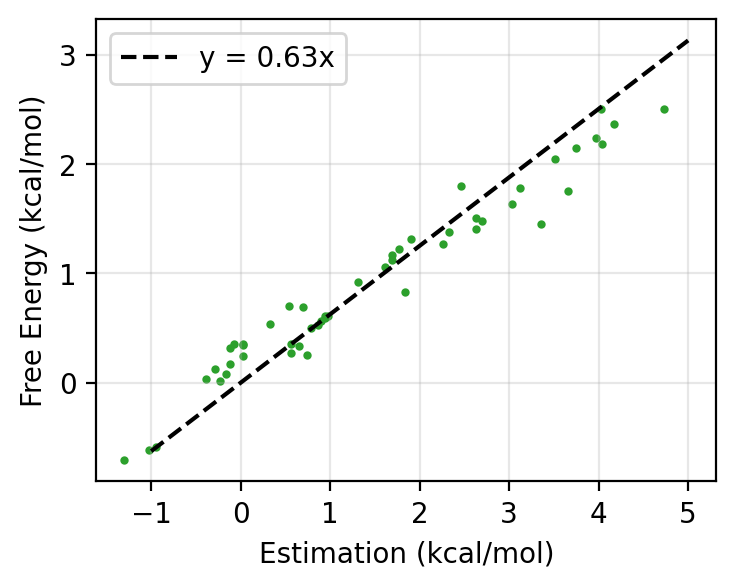

In [ ]:
with open('molecules.list') as mol_file:
    selected_molecules = [line.strip().replace("_", " ") for line in mol_file if ';' not in line]
selected_molecules = molecule_data[molecule_data['Name'].isin(selected_molecules)]
plt.figure(figsize=(4,3), dpi=200)
plt.scatter(selected_molecules['Estimation'], selected_molecules['Free Energy'], s=4, color='tab:green')
slope = np.sum(selected_molecules['Free Energy']) / np.sum(selected_molecules['Estimation'])
print(f"Free Energy = {slope:.2f} * Estimation")
plt.plot(np.linspace(-1, 5), slope * np.linspace(-1, 5), color='black', linestyle='--', label=f'y = {slope:.2f}x')
plt.ylabel('Free Energy (kcal/mol)')
plt.xlabel('Estimation (kcal/mol)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [11]:
client = MongoClient("mongodb://localhost:27017")
database = client.get_database(f"molecules-4")
db_level_0 = database.get_collection(f"level-0")
full_data = []
for molecule in db_level_0.find():
    estimated_energy = bead_mapping(molecule['bead_names']) * slope
    full_data.append((molecule['name'], *molecule['latent_space'], estimated_energy))
full_data = pd.DataFrame(full_data, columns=['Name', *[f'Dimension {i}' for i in range(5)], 'Estimation'])

In [12]:
update_list = []
for idx, row in full_data.iterrows():
    update = {'prior': row['Estimation']}
    update_list.append(UpdateOne({"name": row['Name']}, {"$set": update}))
    if idx % 1000 == 0 or idx == full_data.index.max():
        print(idx, end='\r')
        res = db_level_0.bulk_write(update_list)
        update_list = []

In [13]:
for mol in db_level_0.aggregate([{"$sample": {"size": 5}}]):
    print(f"{mol['name']:>35}: {mol['prior']:.3f}")

            C SC SQ+ TP,0-1 0-3 1-2: 1.012
       Q- TC TP TQ+,0-2 0-3 1-2 1-3: 2.171
            SC TC TP TP,0-1 0-2 1-3: 0.789
              P P Q- TN,0-1 0-2 0-3: 2.185
            P SP TP TQ+,0-1 0-3 1-2: 2.576


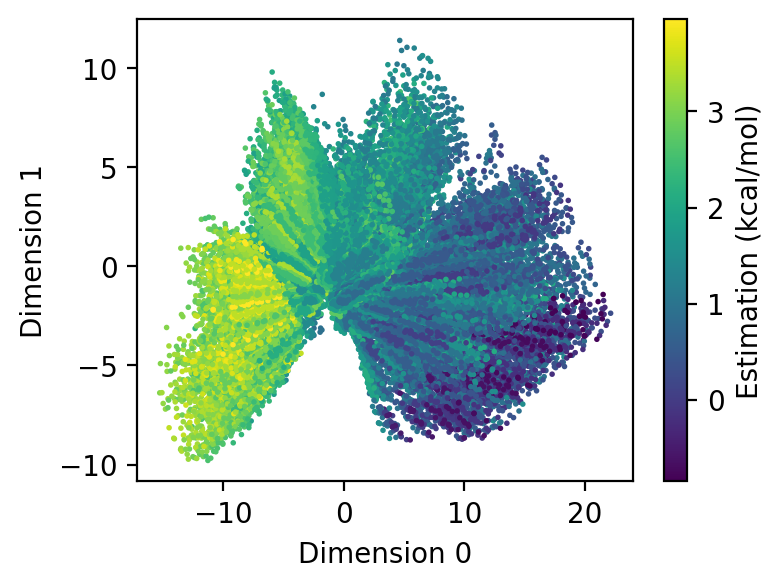

In [17]:
plt.figure(figsize=(4,3), dpi=200)
transformer = PCA(n_components=2)
transformer.fit(full_data[[f'Dimension {i}' for i in range(5)]])
transformed_latent_space = transformer.transform(full_data[[f'Dimension {i}' for i in range(5)]])
plt.scatter(transformed_latent_space[:,0], transformed_latent_space[:,1], c=full_data['Estimation'], cmap='viridis', s=1)
plt.xlabel('Dimension 0')
plt.ylabel('Dimension 1')
plt.colorbar(label='Estimation (kcal/mol)')
plt.show()